In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

In [40]:
housing_data = pd.read_csv('DatenAusgegeben1.2_UTF8_manuell.csv', sep=";", keep_default_na=False)
# print(housing_data.keys())

# Feature Engeneering 
# für €/qm² für besseren Vergleich der Daten
housing_data["Preisproqm"] = housing_data["Preis"]/housing_data["Wohnflaeche in qm"]
# Werte der Heizungsqualitaet in Zahlen umwandeln
housing_data["Heizungsqualitaet"] = [1 if x=="Schl" else 2 if x=="Ud" else 3 if x=="Ty" else 4 if x=="Gut" else 5 for x in housing_data["Heizungsqualitaet"]]
# monate seit 2136
housing_data["Monate"] = (housing_data["Verkaufsjahr"]-2136)*12 + housing_data["Verkaufsmonat"] -1
# Zustand, 1-10 wird auf 1-5 gemapt, das ist zwar ein bisschen ungenauer, aber einfacher zu vergleichen
housing_data["Zustandf"] = [int(x/2) + x%2 for x in housing_data["Zustand"]]

array([2, 3, 4, 5, 1])

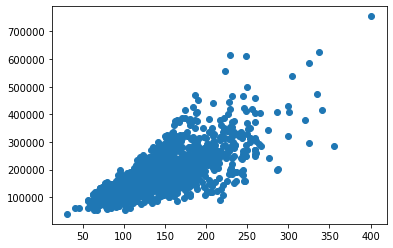

In [4]:
plt.scatter(housing_data["Wohnflaeche in qm"],housing_data["Preis"])
# Hierfür Lineare Regression!

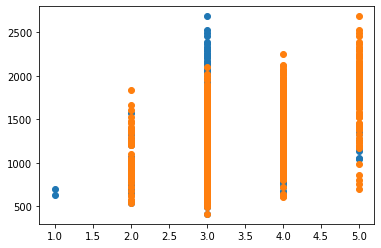

In [35]:
plt.scatter(housing_data["Zustand Fassade"],housing_data["Preis"]/housing_data["Wohnflaeche in qm"])
plt.scatter(housing_data["Kuechenqualitaet"],housing_data["Preis"]/housing_data["Wohnflaeche in qm"])


In [18]:
housing_data.keys()

Index(['Grundstueck in qm', 'Grundstuecksform', 'Steigung', 'Bezirk', 'Zone',
       'Lage', 'Typ', 'Zustand', 'Gebaut', 'Renoviert', 'Zustand Fassade',
       'Kellerflaeche in qm', 'Heizung', 'Heizungsqualitaet', 'Klimaanlage',
       'Erster Stock in qm', 'Zweiter Stock in qm', 'Wohnflaeche in qm',
       'Schlafzimmer', 'Kuechen', 'Kuechenqualitaet', 'Raeume', 'Garage Typ',
       'Garagenkapazitaet', 'Pool', 'Verkaufsmonat', 'Verkaufsjahr', 'Preis'],
      dtype='object')

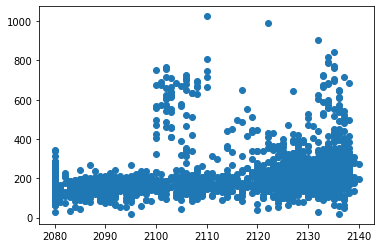

In [19]:
plt.scatter(housing_data["Renoviert"],housing_data["Preis"]/housing_data["Grundstueck in qm"])

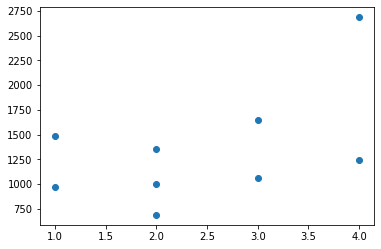

In [47]:
plt.scatter(housing_data["Pool"],housing_data["Preis"]/housing_data["Wohnflaeche in qm"])


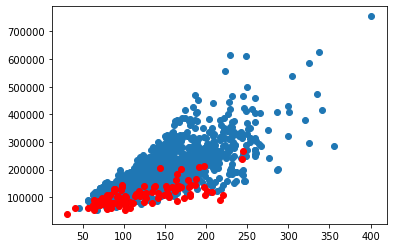

In [54]:
#Klimaanlage
house_ac = housing_data[housing_data.Klimaanlage == "Y"]
house_not_ac = housing_data[housing_data.Klimaanlage == "N"]
plt.scatter(house_ac["Wohnflaeche in qm"],house_ac["Preis"])
plt.scatter(house_not_merac["Wohnflaeche in qm"],house_not_ac["Preis"],c="red")


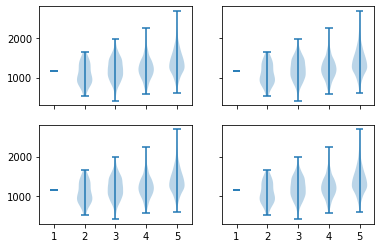

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f13bba93370>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f13bba93190>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f13bb7ca4f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f13bb7ca8b0>}

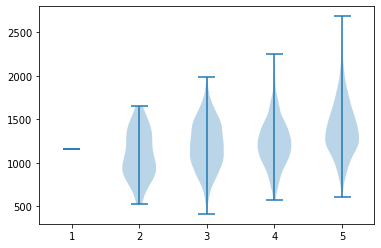

In [26]:
# Florian:
# Heizung, Heizungsqualitaet, Erster Stock in qm, Zweiter Stock in qm, Wohnflaeche in qm, Schlafzimmer, Kuechen, Kuechenqualität, Räume, Garage Typ, Garagenkapazitt, Verkaufsmonat, Verkaufsjahr, Preis
# untersuchen

# Heizung + Qualitaet
heater_types = housing_data["Heizung"].unique()
heater_quality = np.sort(housing_data["Heizungsqualitaet"].unique())
heater_data = [None]*(len(heater_types)+1)

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i in range(len(heater_types)):
    for l in range(len(heater_quality)):
        heater_data[l] = housing_data[housing_data["Heizungsqualitaet"] == heater_quality[l]]["Preisproqm"]
    axs[int(i/2),i%2].violinplot(heater_data)
    
# wie man sehen kann, gibt es nur für die Klimaanlage genügend Werte
# Auch hat die Qualität der Heizung nur bei Klimaanlagen annähernd einen Einfluss
plt.show()

for l in range(len(heater_quality)):
    heater_data[l] = housing_data[housing_data["Heizungsqualitaet"] == heater_quality[l]]["Preisproqm"]
plt.violinplot(heater_data, heater_quality)
# Auch der Überblick nur über die Heizungsqualitaet hat keinen großen Einfluss auf den €/m²

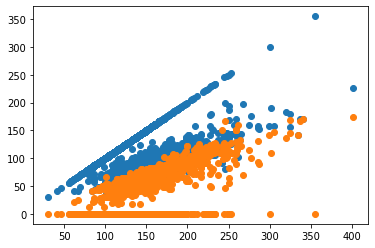

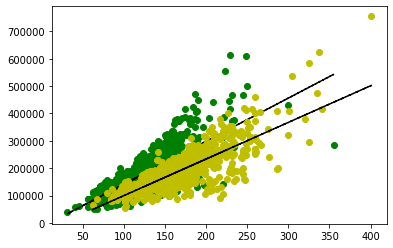

In [97]:
# Erster Stock in qm, Zweiter Stock in qm, Wohnflaeche in qm
# Daten für uns unwichtig, es wird nur kurz darüber geschaut, ob Anomalien und interessante Sachen auftreten

plt.scatter(housing_data["Wohnflaeche in qm"], housing_data["Erster Stock in qm"])
plt.scatter(housing_data["Wohnflaeche in qm"], housing_data["Zweiter Stock in qm"])
plt.show()
# Wie zu erwarten sieht man nicht viel, es gibt sehr viele einstöckige Häuser

one_floor = housing_data[housing_data["Zweiter Stock in qm"] == 0 ]
two_floors = housing_data[housing_data["Zweiter Stock in qm"] != 0 ]


coef = np.polyfit(one_floor["Wohnflaeche in qm"],one_floor["Preis"],1)
poly1d_fn = np.poly1d(coef) 

coef1 = np.polyfit(two_floors["Wohnflaeche in qm"],two_floors["Preis"],1)
poly1d_fn1 = np.poly1d(coef1) 


plt.plot(one_floor["Wohnflaeche in qm"], one_floor["Preis"], 'go', one_floor["Wohnflaeche in qm"], poly1d_fn(one_floor["Wohnflaeche in qm"]), '--k')
plt.plot(two_floors["Wohnflaeche in qm"], two_floors["Preis"], 'yo', two_floors["Wohnflaeche in qm"], poly1d_fn1(two_floors["Wohnflaeche in qm"]), '--k')

plt.show()

# Wohnungen mit mehreren Stockwerken sind bei gleicher Wohnfläche durchweg billiger

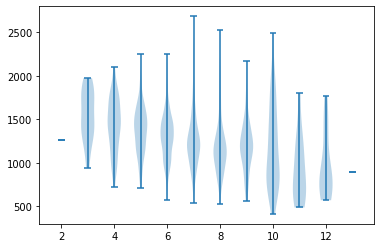

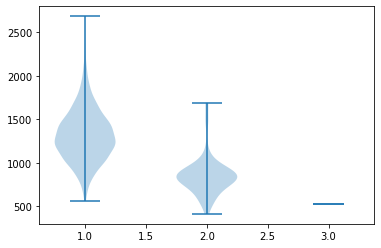

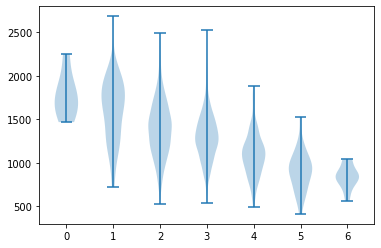

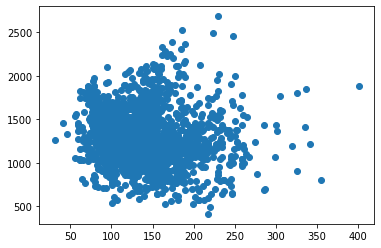

In [98]:
# Schlafzimmer, Kuechen, Räume

# idee: je mehr Räume im Vergleich zu Wohnfläche -> billiger

rooms = np.sort(housing_data["Raeume"].unique())
room_data = [None]*len(rooms)
for i in range(len(rooms)):
    room_data[i] = housing_data[housing_data["Raeume"] == rooms[i]]["Preisproqm"]


plt.violinplot(room_data, rooms)
plt.show()
# ideale Raumzahl liegt bei 7/8 Raeumen

kitchens = np.sort(housing_data["Kuechen"].unique())
kitchen_data = [None]*len(kitchens)
for i in range(len(kitchens)):
    kitchen_data[i] = housing_data[housing_data["Kuechen"] == kitchens[i]]["Preisproqm"]

plt.violinplot(kitchen_data, kitchens)
plt.show()
# Die Anzahl der Kuechen haben wohl keinen Einfluss, oder 1 Kueche > 2?


bedrooms = np.sort(housing_data["Schlafzimmer"].unique())
bedroom_data = [None]*len(bedrooms)
for i in range(len(bedrooms)):
    bedroom_data[i] = housing_data[housing_data["Schlafzimmer"] == bedrooms[i]]["Preisproqm"]

plt.violinplot(bedroom_data, bedrooms)
plt.show()
# Die Anzahl der Schlafzimmer ist komisch, 1 Schlafzimmer ist am beliebtesten? Vllt sind sehr kleine Wohnflächen teurerer als im Vergleich?
plt.scatter(housing_data["Wohnflaeche in qm"],housing_data["Preisproqm"])
# Schwer zu sagen, wahrscheinlich aber nicht


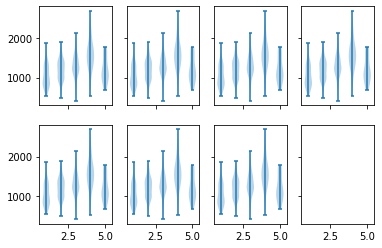

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f13bb3f8d90>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f13bb3f8be0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f13bb388340>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f13bb3f8b80>}

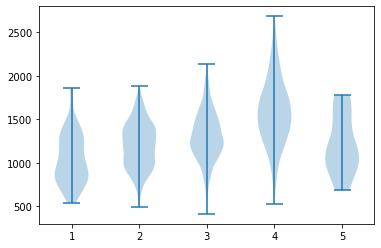

In [33]:
#Garage Typ, Garagenkapazitaet
# wahrscheinlich -> mehr Garagen -> teurer?

garage_types = housing_data["Garage Typ"].unique()

garage_capacity = np.sort(housing_data["Garagenkapazitaet"].unique())
garage_data = [None]*(len(heater_types)+1)

fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)

for i in range(len(garage_types)):
    for l in range(len(garage_capacity)):
        garage_data[l] = housing_data[housing_data["Garagenkapazitaet"] == garage_capacity[l]]["Preisproqm"]
    axs[int(i/4),i%4].violinplot(garage_data)

plt.show()
# Anbaugaragen sind mitunter am teuersten, wobei die anderen im €/qm Bereich sind, wie, wenn keine Garage vorhanden ist
# Der Einfluss von Garagen auf den Preis ist nicht signifikant

for i in range(len(garage_capacity)):
    garage_data[i] = housing_data[housing_data["Garagenkapazitaet"] == garage_capacity[i]]["Preisproqm"]

plt.violinplot(garage_data)
# Auch der Überblick nur über die Garagenkapazitaet hat keinen großen Einfluss auf den €/m²

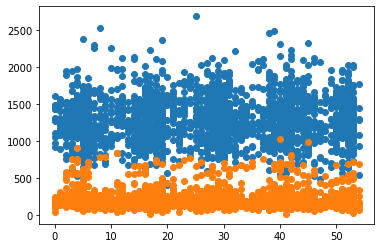

In [35]:
# Verkaufsmonat, Verkaufsjahr, Preis
# Verkaufsmonat sollte weniger einfluss auf den Preis haben
# Verkaufsjahr sollte einen Anstieg wegen der Erhöhung der Mietpreise aufzeigen


plt.scatter(housing_data["Monate"],housing_data["Preisproqm"])
plt.scatter(housing_data["Monate"],housing_data["Preis"]/housing_data["Grundstueck in qm"])
plt.show()
# es gibt keinen Anstieg zwischen den Jahren
# Es werden teurere Wohnungen in den Sommermonaten verkauft, auch deutlich mehr

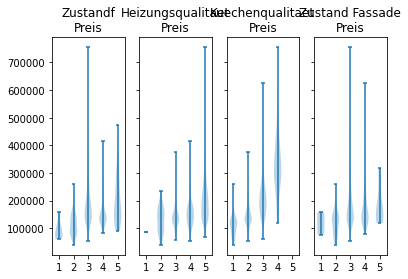

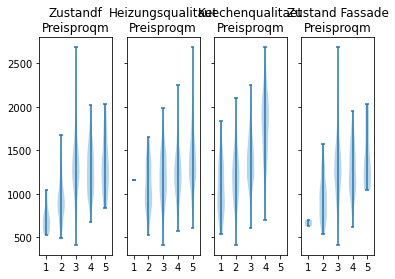

In [65]:
# Heizungsqualitaet, Kuechnqualitaet, Fassadenqualitaet und Zustand 
# (Zustandf, damit ein Vergleich einfacher moeglich ist)


keys = ["Zustandf", "Heizungsqualitaet", "Kuechenqualitaet", "Zustand Fassade"]
rows = ["Preis", "Preisproqm"]

for f in range(len(rows)):
    fig, axs = plt.subplots(1, len(keys), sharex=True, sharey=True)
    for x in range(len(keys)):
        quality = np.sort(housing_data[keys[x]].unique())
        data = [None]*len(quality)
        for i in range(len(quality)):
            data[i] = housing_data[housing_data[keys[x]] == quality[i]][rows[f]]
        axs[x].violinplot(data)
        axs[x].set_title(str(keys[x] + "\n" + rows[f]))
        axs[x].set_xticks([1,2,3,4,5])
    plt.show()
    
    
    # Man kann einige preisliche Anstiege sehen, besonders bei der Kuechenqualität vs Preis
    # da ist wohl nur das Problem, dass der rest der Wohnung wohl auch luxurioeser wird und 
    # das für die Arbeit NICHT gewollt ist, ( es soll Geld mit einzelnen, wenn auch mehreren Renovationen gemacht werden
    # nicht mit einem Umbau in ein neues Haus!)
    # hier sehen wir mehrere Ausreisser bei dem Verkaufspreis, diese sind aber für die weitere Arbeit nicht sehr wichtig, 
    # da es genug weitere Datenpunkte gibt.